<a href="https://colab.research.google.com/github/pycoyle/risksim/blob/master/CPU_vs_GPU_vs_TPU_perf_colab_calcs.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [0]:
#@title Installs & imports
#!pip install -q --upgrade tensorflow
!pip install -q --upgrade tf-quant-finance
#!pip install -q  tensorflow-probability
#!pip install -q --upgrade matplotlib
import numpy as np
import tensorflow.compat.v2 as tf
import tf_quant_finance as tff
import tensorflow_probability as tfp
import time
from tf_quant_finance.rates import forwards

In [0]:
tf.compat.v1.enable_eager_execution


<function tensorflow.python.framework.ops.enable_eager_execution>

In [0]:
#@title Datetime array functions

day = np.timedelta64(1, 'D')
month = np.timedelta64(1, 'M')
year = np.timedelta64(1, 'Y')
daydtype = '<m8[D]'

def year_fraction(dates, ref_date):
  return (dates - ref_date).astype(dtype) / 360.

def radd(dt64, td):
  if td.dtype == daydtype:
    return dt64 + td
  m = dt64.astype('<M8[M]')
  return m + td + (dt64 - m)

def rsub(dt64, td):
  if td.dtype == daydtype:
    return dt64 - td
  m = dt64.astype('<M8[M]')
  return m - td + (dt64 - m)

#def random_date_between(min_dates, max_dates, size=None):
#  dt = max_dates - min_dates
#  if size is None:
#    rndfracs = np.random.rand(*(dt.shape))
#  else:
#    rndfracs = np.random.rand(size)
#  return min_dates + dt * rndfracs


## Hull White future yield curves.

For the single factor Hull white model, the conditional forward bond prices are of the [affine form](https://en.wikipedia.org/wiki/Hull%E2%80%93White_model#Bond_pricing_using_the_Hull%E2%80%93White_model):

$$P(S, T) = A(S, T) e^{-B(S,T) r(S)}$$

where

$$B(S, T) = \frac{1}{\alpha} \left(1 - e^{-\alpha (T-S) } \right)$$

and

$$\begin{eqnarray}
\ln A(S, T) &=& \ln \frac{P(0, T)}{P(0, S)} + B(S, T) f(0, S) - \frac{\sigma^2}{4\alpha^3}\left[1-e^{-\alpha (T-S)}\right]^2 (1-e^{-2\alpha S}) \\
&=& \ln \frac{P(0, T)}{P(0, S)} + B(S, T) f(0, S) - \frac{\sigma^2}{4\alpha}B(S,T)^2 (1-e^{-2\alpha S})
\end{eqnarray}
$$

and
$$f(0, S) = -\frac{\partial}{\partial S} \ln P(0, S)$$

Assuming we are given the pair $(S, r(S))$, we can use the above to compute the discount factors as "observed" at time $S$. The set of future times will be given to us and the $r$ at those times will be computed by sampling (see next section.).

## Implementation details

Doing everything in a vectorized manner leads to a bestiary of shapes. The following gives a guide to the process.

### Indices

There are a few different indices to distinguish. The conventions are as follows

  1. Scenarios: Greek indices: $\mu, \nu$ etc. Take values between $1$ and $N_S$ the number of scenarios.
  2. Currencies: There are many currencies and or basis curves for those currencies to consider. Strictly speaking, we will consider a "currency" to be equivalent to a single HW model. The index for this will be lower case roman from the earlier part of the alphabet e.g. $a, b, c$ etc. These will take values between $1$ and $N_c$ the number of currencies.
  3. Calculation dates: These are a sequence of dates starting from today. For each calculation date, we need to pretend that we are on that date and then age the portfolio and price. The index for calculation dates will be $i, j, k$ etc. Take values between $1$ and $M_c$ the number of calculation dates.
  4. Evaluation dates: These are the dates at which we will want to evaluate the discount factors. In practice these will be the dates from the swap schedules but for the function at hand, these could be any dates. Indexed by $p, q, r$ etc. Take values between $1$ and $N_e$ the number of evaluation dates.

### Input data

1. Short Rate: From the simulation of the Hull-White models we will receive the short rate at each calculation date for each scenario and each currency. Hence the input tensor will be represented as $R_{a \mu i}$ which is the short rate value drawn for scenario $\mu$ for the currency $a$ at calculation date $i$.
2. $CD_i$: The tensor of calculation dates. The i'th calculation date.
3. $MR_a$: The mean reversion strength of the HW model for the $a$'th currency.
4. $\sigma_a$: The volatility of the HW model for the $a$'th currency.
5. $ED_p$: The tensor of evaluation dates. The dates at which the discounts have to be calculated.
6. $A_p$: The currency label for the evaluation dates. Takes values in the set of currencies (i.e. $A_p \in \{1, \cdots, N_c\}$). Hence the joint specification of $(ED_p, A_p)$ means that the p'th element requires us to calculate the discount factor for the currency $A_p$ at time $ED_p$ in every scenario and for every calculation date.
7. Todays Discount and Forward functions. $DFF$. This is a callable that will take two arguments. The first argument will be a set of dates in the future and the second paired argument will be a set of indices, one for each date which will indicate which currencies discount curves we want to invoke. The return will be a tuple. The first will be the log discount to the supplied date for the supplied currency and the second is the instantaneous forward for the supplied date and the currency.

### Output

$DF_{p \mu i}$: the discount factor as seen on the calculation date $CD_i$ to date $ED_p$ for currency $A_p$ in scenario $\mu$. Note that it may happen that $ED_p < CD_i$ in which case, we return some sentinel value (possibly 0).


### Calculation

Main formula

$$
\ln DF_{p \mu i} = \left(\ln A\right)_{p \mu i} - (B * R)_{p \mu i}
$$

Define these "gather" operations:

$$\begin{eqnarray}
MR_{p} &\equiv& MR_{A_p} \\
\sigma_{p} &\equiv& \sigma_{A_p} \\
R_{p \mu i} &\equiv& R_{A_p \mu i}
\end{eqnarray}$$

Then
$$
B_{p \mu i} = \frac{1}{MR_{p}} \left( 1 - \exp^{-MR_p (ED_p - CD_i)}\right)
$$

Note that in fact, $B$ is not a function of index $\mu$ (i.e. scenario). Hence
$$B_{p \mu i} \equiv B_{p i}$$.

Similarly to the $B$ term, the $\ln A$ term doesn't depend on the scenario either so we drop the index $\mu$. We also first need to compute some preliminaries.

$$\begin{eqnarray}
(lnP)_{p} &=& DFF(ED_p, A_p)[0] \\
(lnP')_{p i},\  f_{p i} &=& DFF(CD_i, A_p)[0],\  DFF(CD_i, A_p)[1]
\end{eqnarray}$$

Note that the first equation has no dependence on $i$. Then,

$$
(\ln A)_{pi} = (lnP)_{p} - (lnP')_{pi} + B_{p i} * f_{p i} - \frac{(\sigma_p B_{p i})^2}{4 MR_p} * \left(1 - e^{-2 * MR_p * CD_i}\right)
$$



In [0]:
#@title Parameters to create random calibrations

# The HW model needs a mean reversion parameter per RV. 
# We will set a ninimum MR to stop the curves drifting off too far 
# and a random element to make the currencies behave differently. 

# Random multi-variate correlations and vols
mr_min=0.35 #@param            # minimum mean reversion
# scale factor for random mr*rand (+mr_min). 
# This is used to vary MR randomly between currencies. 
mr_random=0.05 #@param    

# This is used to vary Vol randomly between currencies. 
vol_scale=0.30 #@param    


In [0]:
#@title Define the simulaton parameters

initial_short_rate    = 0.03 #@param
flat_zero_curve_level = 0.03 #@param


dtype = np.float32         #@param  # we can switch between np.float64 and np.float32
num_calculation_dates=208  #@param  # We'll set weekly timepoints for 2 years = 104 
num_scenarios=1000           #@param  # Scenarios = 10, just for testing. 
# only simulating one currency in this example but the Vector model needs at 
# correlated short rate evoluiton - so simulate 2 short rates but only use 1.  
num_currencies=100 #@param            # Need at least 2 currencies for this vector model. 

todays_date = '2020-01-09' #@param

In [0]:
#@title TF implementation of scenario discount curves.

def log_scenario_zeros_with_times(
    short_rates,
    calc_times,
    eval_times,
    currency_groups,
    current_disc_fwd_fn,
    mean_revs,
    sigmas):
  """Computes forward discount factors.

  Produces P(S, T) i.e. the discount factor as seen at time 'S' the calculation date
  for expiry at time 'T' the evaluation date.

  Time today is 0. The eval times are allowed to be negative but not the calc times

  Args:
    short_rates: The short rates of shape: [N_scenarios, Num_calc_dates, Num_currencies].
    calc_times: The calculation times of shape [Num_calc_dates]
    eval_times: The evaluation dates of shape [Num_eval_dates]
    currency_groups: The currency groups of shape [Num_eval_dates] (i.e. same as eval_dates)
    currency_disc_fwd_fn: A callable as described above. Takes two arguments and return a 2-tuple.
    mean_revs: A tensor of shape [num_currencies] The mean reversions for each HW model.
    sigmas: A tensor of same shape as mean_revs.
  
  Returns: A tensor of shape [N_scenarios, num_calc_dates, num_eval_dates]
  """
  mean_revs_p = tf.gather(mean_revs, currency_groups)

  calc_times = tf.expand_dims(calc_times, axis=-1)  # Prepare for broadcasting with eval_dates.
  start_times = tf.zeros_like(calc_times, dtype=dtype)

  
  eval_times_from_calc_times = eval_times - start_times

  
  b_exp = mean_revs_p * eval_times_from_calc_times  # shape [N_calc_dates, n_eval_dates]
  b = (1 - tf.exp(-b_exp)) / mean_revs_p
  lnP_p = current_disc_fwd_fn(eval_times, currency_groups)[0]  # shape [n_eval_dates]
  lnP_den, inst_fwd = current_disc_fwd_fn(calc_times, currency_groups)  # output of shapes [n_calc_dates, n_eval_dates]
  sigma_p = tf.gather(sigmas, currency_groups)
  
  lnA = lnP_p + b * inst_fwd - ((sigma_p * b) ** 2) * (1 - tf.exp(-2 * mean_revs_p * calc_times))
 
  short_rates_p = tf.gather(short_rates, currency_groups, axis=-1)
  raw_result = (lnA - b * short_rates_p)
  
  return  raw_result


In [0]:
 #@title Hull White Parameters Generation Functions

from collections import namedtuple

#def instant_forward_rate_fn(times):   
#    rates = tf.ones(num_currencies,dtype=dtype)*0.03*tf.ones_like(times)
#    return rates

def log_flat_discount_fwd_fn(times,currency_groups):
     rates = tf.ones_like(times)*flat_zero_curve_level
     return (-flat_zero_curve_level*times),rates

HullWhiteData = namedtuple('HullWhiteData',
                           ['mean_reversion', 'volatility',
                            'log_discount_fwd_fn'])


def gen_hull_white_params(num_currencies):
  mean_reversion = np.random.rand(num_currencies) * mr_random+mr_min
  volatility     = np.random.rand(num_currencies) * vol_scale
  
  return HullWhiteData(
     mean_reversion=mean_reversion,
     volatility=volatility,
     log_discount_fwd_fn=log_flat_discount_fwd_fn)


# On Graph Calculations

1. Using Hull-White Parameters generated above ('hull_white_params') and the calculation dates ('calc_dates/calc_times') generate a number of paths for the
short rate. The number of paths should be 'num_scenarios'.
2. In this example all the swap pricing is removed to emphasise focus in on the simulation dynamics ( Hull-White). 


In [0]:
#@title Generate short rates. 
# Calibration for the correlations is random in this example
# Initial T0 discount rate is fixed at a flat rate ( defauly 3%) for all currencies

def generate_short_rates(initial_short_rates, 
                         num_currencies, 
                         hull_white_params, 
                         times, num_scenarios,
                         dtype):
  
  # We will support multiple risk factors which can be correlatetd
  # To test we will generate a random symetric matrix with a unitary diagonal. 
  
  np.random.seed(123) # Setting the seed for repeatability ()
  a = dtype(hull_white_params.mean_reversion)
  sigma = dtype(hull_white_params.volatility)
  corr_matrix = np.random.normal(size=[num_currencies, num_currencies, num_currencies])
  corr_matrix = np.matmul(corr_matrix, np.transpose(corr_matrix, [0, 2, 1]))
  corr_matrix = np.mean(corr_matrix, 0)
  corr_matrix *= 1 / np.diag(corr_matrix)
  corr_matrix = dtype(corr_matrix)

  # The hull white model needs a function to return the T0 forward rates
  # as we currently have a flat zero curve, forward will also be flat at T0. 
  # ( in case you were wondering why I'm passing a zero curve as a fwd function)
  # ( TODO) Generalise this to calc forward rates.   
  
  def instant_forward_rate_fn(times):   
    rates = tf.ones(num_currencies,dtype=dtype)*0.03*tf.ones_like(times)
    return rates
  
  
  # We now have enough information to setup the HW process and return the
  # HW paths. Not this is a one factor HW model ( ToDo - generalise to multi-factor)
  process = tff.models.hull_white.VectorHullWhiteModel(
        dim=num_currencies, # The number of currencies to simulate
        mean_reversion=a,   # Mean reversion param per ccy
        volatility=sigma,   # Vol per ccty
        instant_forward_rate_fn=instant_forward_rate_fn, # Calibrate to T0 curve
        corr_matrix=corr_matrix, # Random correlations for now. 
        dtype=dtype)        # Set precision ( so we can  test performance of 32 vs 64 bit on GPUs) 
 
  times = dtype(times)
  sample_paths = tf.function(process.sample_paths)

  paths = sample_paths(
      times,
      num_samples=num_scenarios,
      initial_state=initial_short_rates,
      seed=42)
  return paths


## PREWORK
today = np.datetime64(todays_date)
WEEK = day * 7
calculation_tenor = WEEK  # week

# Fixed points on zero curves
zero_curve_dates=np.array([0.00,0.5,1,2,3,4,5,6,7,8,9,10])     

# Calculation dates Monthly for 10y
calc_dates = radd(today, np.arange(0, num_calculation_dates + 1) * calculation_tenor)
calc_times = year_fraction(calc_dates, today)
num_calc_dates = calc_times.size

# Generate the random correlations and set all T0 curves to 3%
hull_white_params = gen_hull_white_params(num_currencies)

### PREWORK END

In [0]:
## Define the percentiles to display
percentiles=[99,98,95,90,75,50,25,10,5,2,1] #@param # Extract some percentiles
plotcols=['r','m','b','c','g','black','g','c','b','m','r'] # colour the lines for symetry 
  

In [0]:
#@title Run the simulation on a CPU

def Simulate_market(initial_short_rate, 
                         num_currencies, 
                         hull_white_params, 
                         calc_times,
                         eval_times,
                         num_scenarios,
                         dtype):

# This is where the simulation happens
# The short rate tensor is generataed 
# This is then used to calculate discount factors ( and therfore Zero curves)
# for each sceanrio / timepoint
 
  short_rates = generate_short_rates(
        initial_short_rate  * tf.ones([num_currencies], dtype=dtype),  # initial short rates
        num_currencies,
        hull_white_params, 
        calc_times,         
        num_scenarios,
        dtype=dtype)

  # To fix at one ccy - uncomment this line and comment out the ccy group handaling below. 
  #currency_groups = tf.ones(1 , dtype=tf.int32)
  
  # We want to create num_currency curves of 11 points each
  # First expand the currency groups
  ###### Comment out if only one 
  currency_groups = tf.range(0,num_currencies , dtype=tf.int32)
  currency_groups = tf.expand_dims(currency_groups,axis=-1)
  currency_groups = tf.tile(currency_groups,tf.constant([1,12]))
  currency_groups = tf.reshape(currency_groups,[-1])
  #second expand the eval_times
  eval_times = tf.tile(eval_times,tf.constant([num_currencies]))
  ###### End of ccy group expansion. 


  current_disc_fwd_fn = hull_white_params.log_discount_fwd_fn
  mean_revs = tf.constant(hull_white_params.mean_reversion, dtype=dtype)
  sigmas = tf.constant(hull_white_params.volatility, dtype=dtype)

  log_discounts = log_scenario_zeros_with_times(
        short_rates,
        calc_times,
        eval_times,
        currency_groups,
        current_disc_fwd_fn,
        mean_revs,
        sigmas)
  return log_discounts, eval_times

#eval_times = tf.constant(zero_curve_dates, dtype=dtype)
#log_discounts, eval_times = Simulate_market(initial_short_rate, 
#                         num_currencies, 
#                         hull_white_params, 
#                         calc_times,
#                         eval_times,
#                         num_scenarios,
#                         dtype)


In [0]:
13.5 /2.5



5.4

In [0]:
#@title Sim for plots

walltime = time.time()
with tf.device("/tpu:0"):
 eval_times = tf.constant(zero_curve_dates, dtype=dtype)
 log_discounts, eval_times = Simulate_market(initial_short_rate, 
                         num_currencies, 
                         hull_white_params, 
                         calc_times,
                         eval_times,
                         num_scenarios,
                         dtype) 
 profiles = tfp.stats.percentile( -log_discounts/eval_times, q=percentiles, axis=[0])
walltime = time.time()-walltime
print("exectime:", walltime)

exectime: 11.796652793884277


In [0]:
walltime = time.time()
with tf.device("/gpu"):
  eval_times = tf.constant(zero_curve_dates, dtype=dtype)
  log_discounts, eval_times = Simulate_market(initial_short_rate, 
                         num_currencies, 
                         hull_white_params, 
                         calc_times,
                         eval_times,
                         num_scenarios,
                         dtype) 
  profiles = tfp.stats.percentile( -log_discounts/eval_times, q=percentiles, axis=[0])
walltime = time.time()-walltime
print("exectime:", walltime)

exectime: 2.6952359676361084


In [0]:
walltime = time.time()
#with tf.device("/cpu:0"):
eval_times = tf.constant(zero_curve_dates, dtype=dtype)
log_discounts, eval_times = Simulate_market(initial_short_rate, 
                         num_currencies, 
                         hull_white_params, 
                         calc_times,
                         eval_times,
                         num_scenarios,
                         dtype) 
profiles = tfp.stats.percentile( -log_discounts/eval_times, q=percentiles, axis=[0])
walltime = time.time()-walltime
print("exectime:", walltime)

exectime: 2.818077802658081


In [0]:

walltime = time.time()
with tf.device("/tpu:0"):
 eval_times = tf.constant(zero_curve_dates, dtype=dtype)
 log_discounts, eval_times = Simulate_market(initial_short_rate, 
                         num_currencies, 
                         hull_white_params, 
                         calc_times,
                         eval_times,
                         num_scenarios,
                         dtype) 
 profiles = tfp.stats.percentile( -log_discounts/eval_times, q=percentiles, axis=[0])
walltime = time.time()-walltime
print("exectime:", walltime)

exectime: 11.749044179916382


In [0]:
#@title Time the simulation on a CPU
%%timeit 
with tf.device("/tpu:0"):
 eval_times = tf.constant(zero_curve_dates, dtype=dtype)
 log_discounts, eval_times = Simulate_market(initial_short_rate, 
                         num_currencies, 
                         hull_white_params, 
                         calc_times,
                         eval_times,
                         num_scenarios,
                         dtype) 
 profiles = tfp.stats.percentile( -log_discounts/eval_times, q=percentiles, axis=[0])
 

1 loop, best of 3: 11.6 s per loop


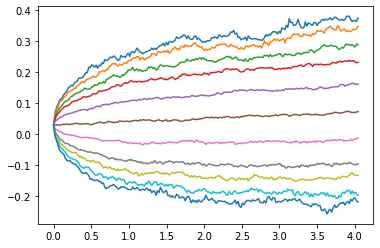

In [0]:
#@title plot a chart
import matplotlib.pyplot as plt
%matplotlib inline
for i in range(0,len(percentiles)):
    plt.plot(calc_times,profiles[i,:,2])

In [0]:
!cat /proc/cpuinfo


processor	: 0
vendor_id	: GenuineIntel
cpu family	: 6
model		: 63
model name	: Intel(R) Xeon(R) CPU @ 2.30GHz
stepping	: 0
microcode	: 0x1
cpu MHz		: 2300.000
cache size	: 46080 KB
physical id	: 0
siblings	: 40
core id		: 0
cpu cores	: 20
apicid		: 0
initial apicid	: 0
fpu		: yes
fpu_exception	: yes
cpuid level	: 13
wp		: yes
flags		: fpu vme de pse tsc msr pae mce cx8 apic sep mtrr pge mca cmov pat pse36 clflush mmx fxsr sse sse2 ss ht syscall nx pdpe1gb rdtscp lm constant_tsc rep_good nopl xtopology nonstop_tsc cpuid tsc_known_freq pni pclmulqdq ssse3 fma cx16 pcid sse4_1 sse4_2 x2apic movbe popcnt aes xsave avx f16c rdrand hypervisor lahf_lm abm invpcid_single ssbd ibrs ibpb stibp fsgsbase tsc_adjust bmi1 avx2 smep bmi2 erms invpcid xsaveopt arat md_clear arch_capabilities
bugs		: cpu_meltdown spectre_v1 spectre_v2 spec_store_bypass l1tf mds swapgs itlb_multihit
bogomips	: 4600.00
clflush size	: 64
cache_alignment	: 64
address sizes	: 46 bits physical, 48 bits virtual
power manageme

In [0]:
from tensorflow.python.client import device_lib
device_lib.list_local_devices()

[name: "/device:CPU:0"
 device_type: "CPU"
 memory_limit: 268435456
 locality {
 }
 incarnation: 4908776984760871669, name: "/device:XLA_CPU:0"
 device_type: "XLA_CPU"
 memory_limit: 17179869184
 locality {
 }
 incarnation: 12563137289952536472
 physical_device_desc: "device: XLA_CPU device"]

In [0]:
######
###### This next bit is is for running on TPU's
###### The easisest way to do this is on GCP with 
###### 
#Now Disable eager execution and test on TPUs
#tf.compat.v1.disable_eager_execution()
#tf.compat.v1.reset_default_graph()